In [1]:
import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
## Open the image
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)

n = 10000

finalArray = np.empty((n, 3, 24, 24))
for i in range(100):
    for j in range(100):
        a, b = 24 * i, 24 * (i + 1)  
        c, d = 24 * j, 24 * (j + 1) 
        idx = j + i * (100)
        finalArray[idx,0,:,:] = imgArray[a:b,c:d,0]
        finalArray[idx,1,:,:] = imgArray[a:b,c:d,1]
        finalArray[idx,2,:,:] = imgArray[a:b,c:d,2]


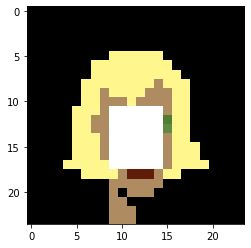

In [2]:
temp  =  finalArray[0,:,:,:].copy()

d2min, d2max = 9,14 
d1min, d1max = 11,17

temp[:,d1min : (d1max + 1), d2min : (d2max + 1)] = 255

plt.imshow(np.transpose(temp,(1,2,0)).astype('uint8'))

In [3]:
cancerpunks = finalArray.copy()
label = np.zeros(n)

## Loop over the cryptopunks
for i in range(10000):
    flip = np.random.randint(0, 2)
    if flip == 1:
        label[i] = 1
        d1loc = np.random.randint(d1min, d1max + 1)
        d2loc = np.random.randint(d2min, d2max + 1)
        cancerpunks[i,:,d1loc,d2loc] = 255


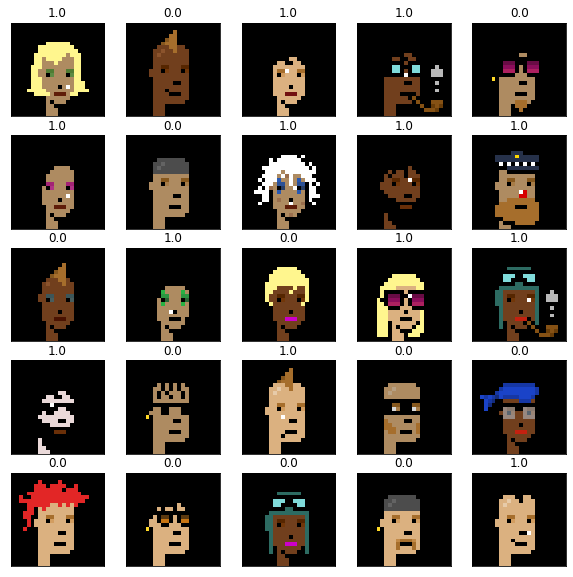

In [4]:
## plot some examples
plt.figure(figsize=(10,10))
for i in range(25): 
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.transpose(cancerpunks[i,:,:,:],(1,2,0)).astype('uint8'))
    plt.title(label[i])

In [5]:
# Normalize array and split into training and testing dataset
n = cancerpunks.shape[0]
trainFraction = 0.75
sample = np.random.uniform(size = n) < trainFraction 
x_train = cancerpunks[sample,:,:,:]/255
x_test = cancerpunks[~sample,:,:,:]/255
[x_train.shape, x_test.shape]

[(7492, 3, 24, 24), (2508, 3, 24, 24)]

In [6]:
y_train = label[sample]
y_test =  label[~sample]

## Need to have the extra dimension
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
[y_train.shape, y_test.shape]

[(7492, 1), (2508, 1)]

In [7]:
# Load train dataset
trainDataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = 100, shuffle = False, num_workers = 1)

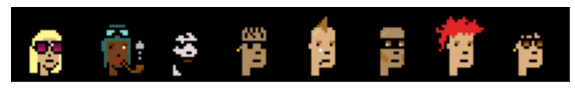

tensor([1., 1., 1., 0., 1., 0., 0., 0.])

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


# show images

plt.figure(figsize = (10, 10))
imshow(torchvision.utils.make_grid(images[11:19, :, :, :]))

# print labels
labels[11 : 19,0]

In [9]:
# CNN model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
net = Net()

In [10]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(300):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        
        running_loss += loss.item()

print('Finished Training')

Finished Training


Accuracy of training set =  0.9742391884676989
Sensitivity of training set =  0.9501915708812261
Specificity of training set =  0.9971339239187077


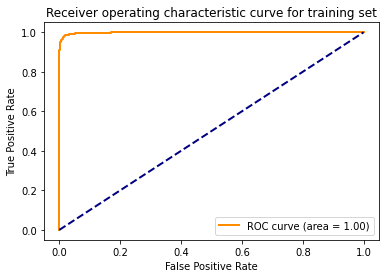

In [12]:
# Training Set result 
trainout = net(torch.Tensor(x_train)).detach().numpy()

fpr, tpr, thresholds = roc_curve(y_train, trainout)
roc_auc = auc(fpr, tpr)

# Accuracy, sensitivity and specificity 
train_pred = np.where(trainout > 0.5, 1, 0)

matrix = confusion_matrix(y_train,train_pred)
TN, FP, FN, TP = confusion_matrix(y_train,train_pred).ravel() 
    
train_acc = accuracy_score(y_train, train_pred)
train_sen = TP/float(FN+TP)
train_spe = TN/float(TN+FP)

print( 'Accuracy of training set = ',train_acc)
print('Sensitivity of training set = ',train_sen) 
print( 'Specificity of training set = ',train_spe)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for training set')
plt.legend(loc="lower right")
plt.show()



Accuracy of testing set =  0.94377990430622
Sensitivity of testing set =  0.9126290706910246
Specificity of testing set =  0.9751801441152922


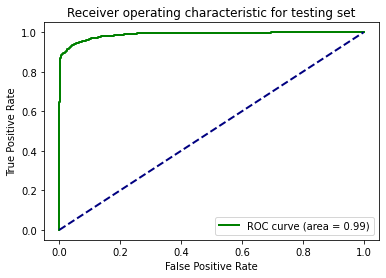

In [13]:
## Run the testing data through the NN
testout = net(torch.Tensor(x_test)).detach().numpy()

## Compare with the testing labels
fpr, tpr, thresholds = roc_curve(y_test, testout)
roc_auc = auc(fpr, tpr)

# Accuracy, sensitivity and specificity 
test_pred = np.where(testout > 0.5, 1, 0)
matrix = confusion_matrix(y_test,test_pred)
TN, FP, FN, TP = confusion_matrix(y_test,test_pred).ravel() 
    
test_acc = accuracy_score(y_test, test_pred)
test_sen = TP/float(FN+TP)
test_spe = TN/float(TN+FP)

print( 'Accuracy of testing set = ',test_acc)
print('Sensitivity of testing set = ',test_sen) 
print( 'Specificity of testing set = ',test_spe)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='green',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for testing set')
plt.legend(loc="lower right")
plt.show()

We can see that the accuracy, sensitivity and specificity of training set are 0.97,0.95,0.997 and the accuracy, sensitivity and specificity of testing set are 0.94,0.913,0.975. So the accuracy, sensitivity and specificity of training set are slightly higher than those of testing set. It makes sense because the model is trained with training set but the model has not seen the testing set which could make accuracy, sensitivity and specificity of testing set slightly lower. 

# Find the incorrects

In [14]:
incorrects = np.nonzero(test_pred != y_test)[0]
incorrects

array([  29,   66,   80,   88,  106,  132,  136,  162,  175,  183,  192,
        199,  213,  229,  263,  297,  322,  325,  329,  370,  375,  388,
        395,  401,  410,  452,  456,  473,  485,  544,  565,  578,  605,
        609,  616,  631,  645,  653,  751,  790,  820,  827,  834,  868,
        874,  900,  910,  931,  938,  939,  953,  965,  968,  976,  987,
       1002, 1005, 1009, 1053, 1102, 1104, 1108, 1113, 1125, 1172, 1226,
       1228, 1229, 1247, 1268, 1285, 1316, 1330, 1331, 1345, 1364, 1383,
       1388, 1407, 1420, 1441, 1445, 1446, 1453, 1472, 1482, 1492, 1496,
       1504, 1506, 1540, 1545, 1571, 1608, 1677, 1681, 1709, 1713, 1722,
       1737, 1746, 1762, 1794, 1804, 1817, 1833, 1841, 1865, 1878, 1937,
       1946, 1978, 1985, 1990, 1993, 1996, 2013, 2057, 2061, 2072, 2083,
       2088, 2090, 2108, 2163, 2186, 2227, 2254, 2298, 2334, 2342, 2344,
       2370, 2376, 2412, 2426, 2439, 2444, 2477, 2486, 2498])

In [15]:
test_orig = x_test*255

True label: [0.]
Predicted label: [1]


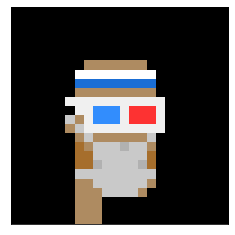

In [21]:
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(test_orig[80,:,:,:],(1,2,0)).astype('uint8'))

print('True label:', y_test[80])
print('Predicted label:', test_pred[80])

This is an example of punks that did not have a cancer but the algorithm declared it very likely to have a cancer. The algorithm might classify some parts of his eyeclasses or hat to be a lesion as parts of his hat and eyeclasses are white. So it could confound the algorithm. 

True label: [1.]
Predicted label: [0]


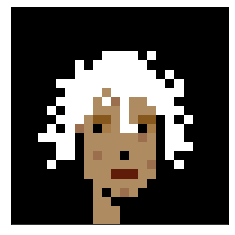

In [17]:
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(test_orig[29,:,:,:],(1,2,0)).astype('uint8'))

print('True label:', y_test[29])
print('Predicted label:', test_pred[29])

This is an example of punks that did have a cancer but the algorithm declared it not likely to have a cancer. This might happen because her hair is white too and the lesion is blended with her hair which made it very hard to differentiate between lesion and hair. Even when I first saw the image, I could also ignore the lesion. Therefore, the algorithm might fail to identify the lesion. 

# Output probabilities

In [36]:
def cancer_prob(img):
    # input img is a numpy array 
    # First convert img to 3D tensor and then turn it to 4D tensor since our model uses 4D tensor
    img = torch.Tensor(img).unsqueeze(0)  
    img = img/255   #normalize the input image 
    output = net(img).detach().numpy()[0][0]
    
    return output

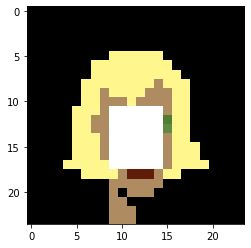

In [37]:
temp  =  finalArray[0,:,:,:].copy()

d2min, d2max = 9,14 
d1min, d1max = 11,17

temp[:,d1min : (d1max + 1), d2min : (d2max + 1)] = 255

plt.imshow(np.transpose(temp,(1,2,0)).astype('uint8'))

In [38]:
cancer_prob(temp)

0.9999999

From this example, we can tell that the predicted probability of this image having a lesion (being in the class '1') is about 0.99999.